In [26]:
import numpy as np
import gp_cake.simulator as sim
import matplotlib.pyplot as plt
%matplotlib inline

/vol/optdcc/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:156: RuntimeWarning: invalid value encountered in divide


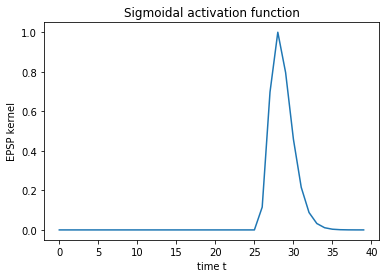

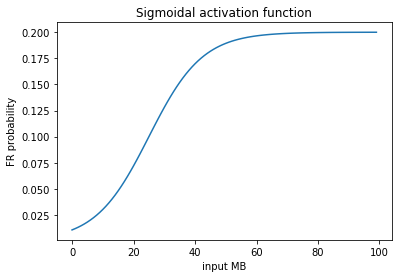

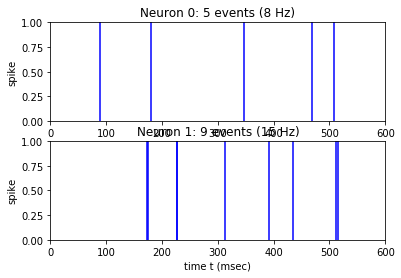

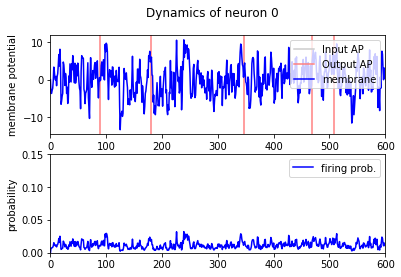

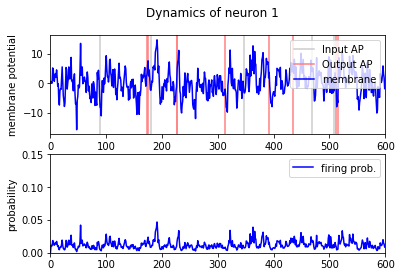

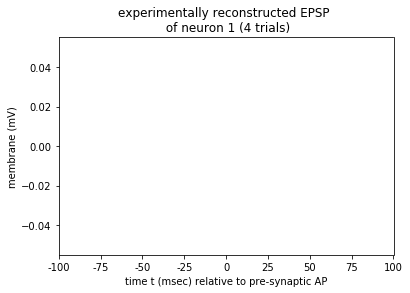

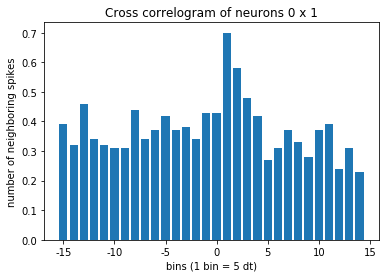

In [32]:
sim_case                        = 0                                                                                                                                                                                                    

if sim_case == 0:
    # simple two-node network (0 --> 1)
    p                           = 2
    adj_mat                     = np.zeros((p,p))
    adj_mat[0,1]                = 1
elif sim_case == 1:
    # transitive three-node network (0 --> 1 --> 2)
    p                           = 3
    adj_mat                     = np.zeros((p,p))
    adj_mat[0,1] = adj_mat[1,2] = 1
else:
    # large sparse/weakly-coupled random network (potentially recurrent)
    p                           = 5
    sparse                      = 0.2
    adj_mat                     = np.zeros((p**2))
    adj_mat[0:int(sparse*p**2)] = 1                                                                                                                                                                                                     
    np.random.shuffle(adj_mat)
    adj_mat                     = adj_mat.reshape((p,p))
    adj_mat[np.diag_indices(p)] = 0


connection_strength     = 0.15

time_step               = 0.001
time_period             = 0.6
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
ntime_points            = int(time_period / time_step)
padding_window          = 50

simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period,
                           'padding'                : padding_window}

ntrials_train           = 100
ntrials_test            = 100

simulation                          = sim.integroDifferential_simulator()
(training_samples, testing_samples) = simulation.simulate_spiking_network_dynamics(ntrials_train, 
                                                                                   ntrials_test, 
                                                                                   simulation_params)

plotOn                  = True      

if plotOn:
    
    
    plt.close('all')    
   
    # plot epsp
    plt.figure(); plt.plot(simulation.neuron_functions["epsp"])
    plt.title('Sigmoidal activation function')
    plt.xlabel('time t'); plt.ylabel('EPSP kernel')
    
    # plot activation function
    plt.figure(); plt.plot(simulation.neuron_functions["sigma"](np.arange(-0,100)))
    plt.title('Sigmoidal activation function')
    plt.xlabel('input MB'); plt.ylabel('FR probability')
    
    # plot Bernoulli spike trains of neurons
    trial = 0
    fig = plt.figure()
    for neuron in range(0,p):
        nAP = training_samples["action_potentials"][trial][neuron,:]
        plt.subplot(p,1,neuron+1)
        spikeIDX = np.nonzero(nAP)[0]
        for idx in np.arange(np.size(spikeIDX)):
            plt.axvline(x=spikeIDX[idx], color = 'b')
        plt.ylabel('spike');
        plt.title('Neuron %s: %d events (%i Hz)' %(neuron,np.sum(nAP >0),np.round(np.sum(nAP >0)/time_period)))
        plt.gca().set_xlim([0, time_period/time_step]); 
    plt.xlabel('time t (msec)');
        
    # plot stats for neurons
    neurons = [0,1]
    for neuron in neurons:
        fig   = plt.figure()
        nAP   = training_samples["action_potentials"][trial][neuron,:]
        preAP = np.dot(adj_mat[:,neuron]>0, training_samples["action_potentials"][trial]) 
        nMB   = training_samples["membrane_potentials"][trial][neuron,:]
        nFR   = training_samples["firing_probabilities"][trial][neuron,:]
        
        plt.subplot(211)
        spikeIDX = np.nonzero(preAP)[0]
        for idx in np.arange(np.size(spikeIDX)):
            plt.axvline(x=spikeIDX[idx], color = (0.8, 0.8, 0.8))
        spikeIDX = np.nonzero(nAP)[0]
        for idx in np.arange(np.size(spikeIDX)):
            plt.axvline(x=spikeIDX[idx], color = (1.0, 0.5, 0.5))
        plt.xlabel('time t (msec)'); plt.ylabel('membrane potential')
        plt.gcf().suptitle('Dynamics of neuron %s' %neuron)
        plt.gca().set_xlim([0, time_period/time_step]);
        plt.plot(nMB, color = 'b')
        plt.legend(('Input AP','Output AP','membrane'),loc='upper right')
        ax = plt.gca(); leg = ax.get_legend()
        if len(leg.legendHandles) >2:
            leg.legendHandles[0].set_color((0.8, 0.8, 0.8))
            leg.legendHandles[1].set_color((1.0, 0.5, 0.5))
            leg.legendHandles[2].set_color('blue')
            
        plt.subplot(212)
        plt.plot(nFR, color = 'b')
        plt.ylabel('probability')
        plt.legend(('firing prob.',),loc='upper right')
        plt.gca().set_xlim([0, time_period/time_step]);
        plt.gca().set_ylim([0, 0.15]);
        
    # compute ERP in response to pre-synaptic spikes 
    # and cross-correlogram between two neurons
    neurons  = [0,1] 
    average_crossCorr = 0
    averave_potential = 0
    for trial in range(ntrials_train):
        preAP    = training_samples["action_potentials"][trial][neurons[0],:]
        postMB   = training_samples["membrane_potentials"][trial][neurons[1],:]
        postAP   = training_samples["action_potentials"][trial][neurons[1],:]
        window   = 100; template= np.zeros(2*window)   # window for ERP analysis
        crossWin = 15; crossCor = np.zeros(2*crossWin) # number of plotted bins for cross-correlogram

        # zero-padd the timeseries to avoid problems with the interval running over the array ends
        node1IDX    = np.nonzero(np.append(np.append(np.zeros(window),preAP),np.zeros(window)))[0]
        postMBpadd  =            np.append(np.append(np.zeros(window),postMB),np.zeros(window))
        node2IDX    = time_step*np.nonzero(postAP)[0]
        node2IDX    = np.append(np.array(0.0),np.append(node2IDX,np.array(time_period)))

        binSize     = 5                                         # size of histogram bins in units of dt
        binNum      = np.int((time_period/time_step)/binSize)   # resulting resolution of bins

        # for each presynaptic unit spike ...
        for ref in node1IDX[node1IDX>0]:
            # ... collect event-related postsynaptic membrane perturbations
            template += postMBpadd[(ref-window):(ref+window)]

            # compute histogram of postsynaptic spike times for cross correlograms
            # ("edges" contains every bin's left interval ending)
            hist, edges = np.histogram(node2IDX, bins=binNum)#dt*np.nonzero(n2AP)[0], bins=binNum)

            # remove the endpoint counts previously added in node2IDX
            hist[0] -=1; hist[-1] -=1

            # find first bin whose left edge comes after the (presynaptic) reference spike
            # (remove zero-padd window of node1IDX and increment index for subsequent zero-padd of length crossWin)
            refBin = crossWin + np.min(np.nonzero(edges >= time_step*(ref-window)))

            # zero-padd the histogram to avoid problems with the interval running over the array ends
            hist  = np.append(np.append(np.zeros(crossWin),hist),np.zeros(crossWin))

            # remember the neighboring spikes (centered around refBin)
            crossCor += hist[refBin-crossWin:refBin+crossWin]


        # normalize epsp template    
        template = template / np.sum(node1IDX>-1)
        average_crossCorr += crossCor
        averave_potential += template
        
    average_crossCorr = average_crossCorr/float(ntrials_train)
    averave_potential = averave_potential/float(ntrials_train)
    
    fig = plt.figure()
    plt.plot(averave_potential)
    plt.title('experimentally reconstructed EPSP \n of neuron %i (%i trials)' %(neurons[1],np.sum(node1IDX>-1)))
    plt.xlabel('time t (msec) relative to pre-synaptic AP'); plt.ylabel('membrane (mV)')
    xTick_posit = np.arange(0,200+1,25)
    xTick_label = np.arange(-100,100+1,25)
    plt.xticks(xTick_posit, xTick_label)
    plt.show()
    
    fig = plt.figure();
    plt.bar(np.arange(2*crossWin),average_crossCorr)
    plt.title('Cross correlogram of neurons %i x %i' %(neurons[0],neurons[1]))
    plt.xlabel('bins (1 bin = %i dt)' %binSize); plt.ylabel('number of neighboring spikes')
    xTick_posit = np.arange(0,30+1,5)
    xTick_label = np.arange(-15,15+1,5)
    plt.xticks(xTick_posit, xTick_label)
    plt.show()